# Cliff Walking Game

## 1. Modelisation

Consider the gridworld shown below. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down,right, and left. Reward is -1 on all transitions except those into the region marked “The Cliff”. Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start.

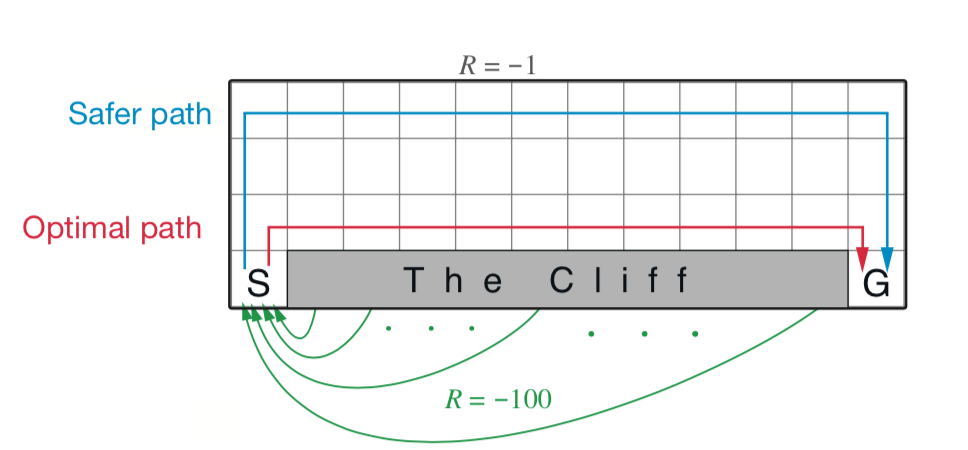

## 2. Init environment

In [ ]:
import numpy as np
import gym
import random
import math
import matplotlib.pyplot as plt

#### 2.1. Cliff Walking class

In [ ]:
class Cliffwalking:
    
    def __init__(self, rows=4, columns=12):
        # Grid parameters (rows x columns)
        self.rows = rows
        self.columns = columns
        self.observation_space = gym.spaces.Discrete(self.rows * self.columns)
        self.grid = []

        # Actions & states initialization
        self.current_state = None
        self.action_space = gym.spaces.Discrete(4)  # 4 actions : up, down, left and right
        self.start = (self.rows-1, 0)
        self.goal = (self.rows-1, self.columns-1)
        
    def reset(self):
        self.current_state = self.start
        self.grid = []
        for i in range(self.rows):
            self.grid.append([' '] * self.columns)
            
        for i in range(self.columns):
            self.grid[self.rows-1][i] = 'C' 
            
        self.grid[self.rows-1][0] = 'R'
        self.grid[self.rows-1][self.columns-1] = 'G'
        
    def render(self):
        for i in range(self.rows):
            print('| ', end='')
            for j in range(self.columns):
                print(f'{self.grid[i][j]} | ', end='')
            print('\n')
        
    def step(self, action):
        # get current state coordinates (x, y)
        x, y = self.current_state
        
        # action : up
        if action == 0:
            if x > 0:
                self.current_state = (x-1, y)
        
        # action : down
        if action == 1:
            if x < self.rows-1:
                self.current_state = (x+1, y)
                
        # action : left
        if action == 2:
            if y > 0:
                self.current_state = (x, y-1)
                
        # action : right
        if action == 3:
            if y < self.columns-1:
                self.current_state = (x, y+1)
                
        # update grid board
        x, y = self.current_state
        self.grid[x][y] = 'R'
        
        # choose reward (-1 or -100)
        if x == self.rows-1:
            if y > 0 and y < self.columns-1:
                reward = -100
                done = True
                
            if y == self.columns-1:
                reward = -1
                done = True
            
            if y == 0:
                reward = -1
                done = False
        else:
            reward = -1
            done = False
        
        # return information (new_state, reward, done, information)
        return self.current_state, reward, done, None
        
    def episode(self):
        self.reset()
        done = False
        while not done:
            # perform random action 
            action = random.choice([0, 1, 2, 3])
            next_state, reward, done, _ = self.step(action)
            self.render()
            
    def bestEpisode(self, Q, render=True):
        self.reset()
        done = False
        best_reward = 0
        while not done:
            # get best action in QTable
            action = max(Q[str(self.current_state)], key=Q[str(self.current_state)].get)

            # excute the selected action
            next_state, reward, done, _ = self.step(action)
            best_reward += reward
        if render:
            self.render()
        return best_reward
    
    def choose_action(self, current_state, Q, Egreedy):
        if random.random() <= Egreedy:
            # random action 
            return random.choice([0, 1, 2, 3])
        else:
            # check if best action is possible (check if Q[current_state] != {0:0.0, 1:0.0, 2:0.0, 3:0.0})
            if any([Q[str(current_state)][action] for action in range(len(Q[str(current_state)]))]):
                # best action in Q(s,a)
                return max(Q[str(current_state)], key=Q[str(current_state)].get)
            else:
                # take random action 
                return random.choice([0, 1, 2, 3])

#### 2.2. Greedy variation function according to the iteration number

In [ ]:
def greedy(index, Time):
    return 0.5 * math.cos((index / (2 * Time)) * math.pi) 

## 3. QLearning algorithm

#### 3.1. QLearning function

In [ ]:
def QLearning(agent, Alpha, Gama, Time, Egreedy, VariableGreedy=False):
    # init Q table 
    Q = {}
    rewards = [0]*Time
    for i in range(agent.rows):
        for j in range(agent.columns):
            Q[str((i,j))] = {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}
        
    for i in range(Time): 
        # init episode 
        agent.reset()
        done = False
        current_state = agent.current_state
        
        # calculate E-Greedy
        if VariableGreedy:
            Egreedy = greedy(i, Time)
            
        # start episode 
        while not done:
            
            # choose action by e-greedy policy
            action = agent.choose_action(current_state, Q, Egreedy)
                
            # excute action selected
            next_state, reward, done, _ = agent.step(action)
            
            # compute the sum of rewards
            rewards[i] += reward
                
            # update Q(state,action)
            value_next_state = max([Q[str(next_state)][action] for action in Q[str(next_state)]])
            Q[str(current_state)][action] += Alpha * (reward + Gama * value_next_state - Q[str(current_state)][action])
            current_state = agent.current_state
                
    return Q, rewards

#### 3.2. Testing Qlearning function

In [ ]:
# Init new learning Agent
QAgent = Cliffwalking()

In [ ]:
# Q-Learning test 
# Parameters : {alpha : 0.1, gama : 0.9, Egreedy : 0.3, time : 1000}
QTable, Qrewards = QLearning(agent=QAgent ,Alpha=0.1, Gama=0.9, Egreedy=0.3, Time=1000)

#### 3.3. Making an episode using QTable found with QLearning function

In [ ]:
print(f'REWARDS : {QAgent.bestEpisode(QTable)}')

|   |   |   |   |   |   |   |   |   |   |   |   | 

|   |   |   |   |   |   |   |   |   |   |   |   | 

| R | R | R | R | R | R | R | R | R | R | R | R | 

| R | C | C | C | C | C | C | C | C | C | C | R | 

REWARDS : -13


#### 3.4. All Rewards & best reward evolution in Qlearning training

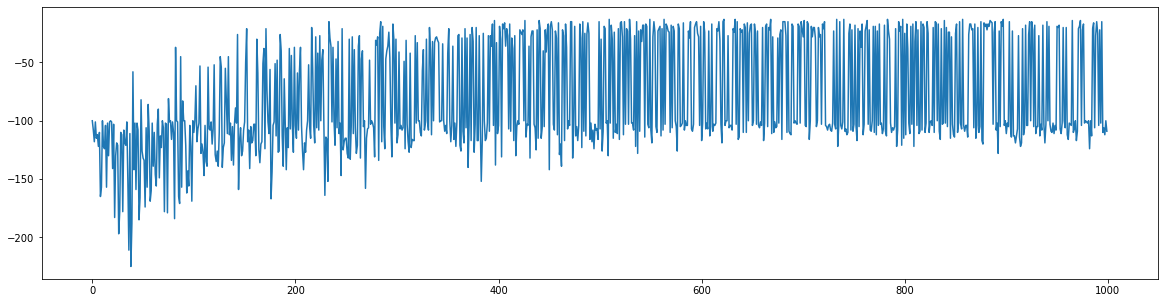

In [ ]:
x = [i for i in range(1000)]
fig = plt.figure(figsize=(20, 5))
plt.plot(x, Qrewards)
plt.show()

## 4. SARSA Algorithm

#### 4.1. SARSA function

In [ ]:
def SARSA(agent, Alpha, Gama, Time, Egreedy, VariableGreedy=False):
    # init Q table 
    Q = {}
    rewards = [0]*Time
    for i in range(agent.rows):
        for j in range(agent.columns):
            Q[str((i,j))] = {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0}
        
    for i in range(Time): 
        # init episode 
        agent.reset()
        done = False
        current_state = agent.current_state
        
        # calculate E-Greedy
        if VariableGreedy:
            Egreedy = greedy(i, Time)
            
            
        # choose first action "action_1" by e-greedy policy
        action_1 = agent.choose_action(current_state, Q, Egreedy)
            
        # start episode 
        while not done:
            # excute action selected
            next_state, reward, done, _ = agent.step(action_1)
            rewards[i] += reward
                
            # choose seconde action "action_2" by e-greedy policy
            action_2 = agent.choose_action(next_state, Q, Egreedy)
                
            # update Q(state,action)
            Q[str(current_state)][action_1] += Alpha * (reward + Gama * Q[str(next_state)][action_2] - Q[str(current_state)][action_1])
            current_state = agent.current_state
            action_1 = action_2
                
    return Q, rewards

#### 4.2. Testing SARSA function

In [ ]:
# Init new learning Agent
SARSA_Agent = Cliffwalking()

In [ ]:
# SARSA test 
# Parameters : {alpha : 0.1, gama : 0.9, Egreedy : 0.3, time : 1000}
SARSA_Table, SARSA_rewards = SARSA(agent=SARSA_Agent ,Alpha=0.1, Gama=0.9, Egreedy=0.3, Time=1000)

#### 4.3. Making an episode using QTable found with SARSA function

In [ ]:
print(f'REWARDS : {SARSA_Agent.bestEpisode(SARSA_Table)}')

| R | R | R | R | R | R | R | R | R | R | R | R | 

| R |   |   |   |   |   |   |   |   |   |   | R | 

| R |   |   |   |   |   |   |   |   |   |   | R | 

| R | C | C | C | C | C | C | C | C | C | C | R | 

REWARDS : -17


#### 4.4. Rewards evolution in SARSA training

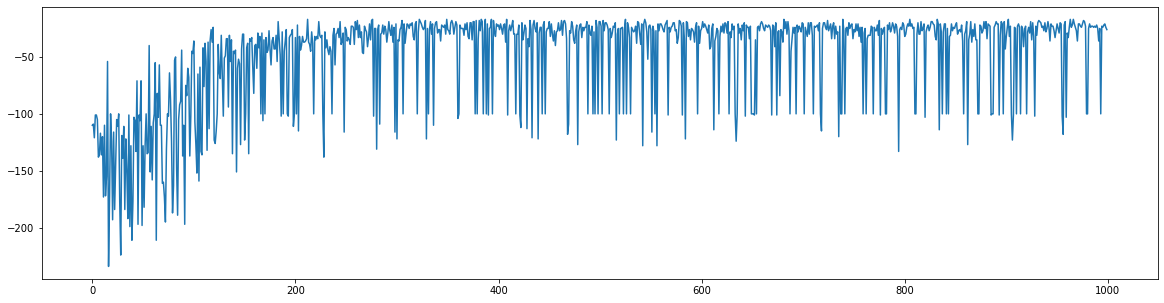

In [ ]:
x = [i for i in range(1000)]
fig = plt.figure(figsize=(20, 5))
plt.plot(x, SARSA_rewards)
plt.show()

## 5. Experimental study on the 'Egreedy' parameter

#### 5.1. Egreedy variation between [0, 1] for QLearning and SARSA during training

In [ ]:
Qbest_rewards = [0]*11
SARSA_best_rewards = [0]*11
for i in range(11):
    _, rewards = QLearning(agent=QAgent ,Alpha=0.1, Gama=0.9, Egreedy=i/10, Time=1000)
    Qbest_rewards[i] = max(rewards) 
    
    _, rewards = SARSA(agent=SARSA_Agent ,Alpha=0.1, Gama=0.9, Egreedy=i/10, Time=1000)
    SARSA_best_rewards[i] = max(rewards)

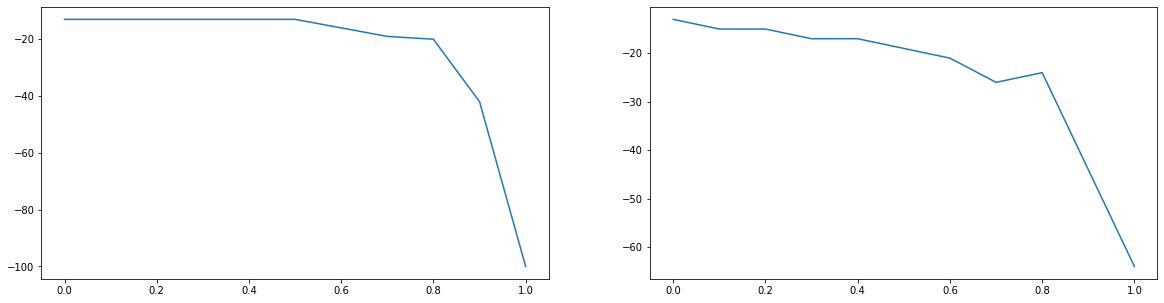

In [ ]:
fig = plt.figure(figsize=(20, 5))
x = [i/10 for i in range(0, 11)]
fig.add_subplot(1, 2, 1)
plt.plot(x, Qbest_rewards)

fig.add_subplot(1, 2, 2)
plt.plot(x, SARSA_best_rewards)
plt.show()

#### 5.2. Variation of Egreedy according to the iteration number

Best rewards QLearning = -13
Best rewards SARSA = -17


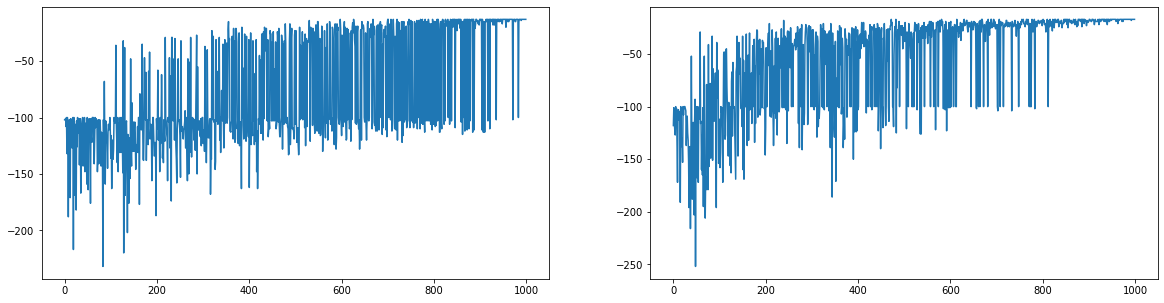

In [ ]:
# execute Qlearning and SARSA with decreasing value of E-greedy according to the iteration number
_, Qrewards = QLearning(agent=QAgent ,Alpha=0.1, Gama=0.9, Egreedy=0, Time=1000, VariableGreedy=True)    
_, SARSA_rewards = SARSA(agent=SARSA_Agent ,Alpha=0.1, Gama=0.9, Egreedy=0, Time=1000, VariableGreedy=True)
    
# display results
fig = plt.figure(figsize=(20, 5))
x = [i for i in range(1000)]
fig.add_subplot(1, 2, 1)
plt.plot(x, Qrewards)
print(f'Best rewards QLearning = {max(Qrewards)}')

fig.add_subplot(1, 2, 2)
plt.plot(x, SARSA_rewards)
print(f'Best rewards SARSA = {max(SARSA_rewards)}')

plt.show()

## 6. Experimental study on the 'convergence speed' parameter

#### 6.1. Best number iteration for finding Best reward during training for QLearning & SARSA

QLEARNING BEST REWARD FOUND IN 472 ITERATIONS
SARSA BEST REWARD FOUND IN 274 ITERATIONS


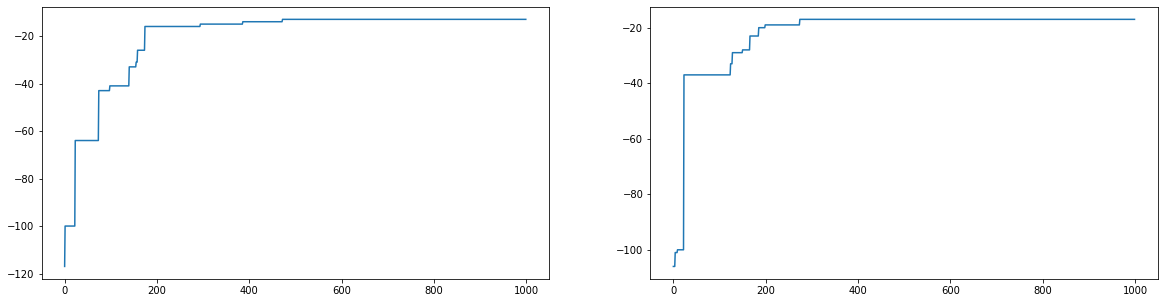

In [ ]:
# training for SARSA & QLearning
_, Qrewards = QLearning(agent=QAgent ,Alpha=0.1, Gama=0.9, Egreedy=0.3, Time=1000)
_, SARSA_rewards = SARSA(agent=SARSA_Agent ,Alpha=0.1, Gama=0.9, Egreedy=0.3, Time=1000)

x = [i for i in range(1000)]
y1 = []
Best = -10000
counter = 0
for reward in Qrewards:
    if reward > Best:
        Best = reward
        BestTime = counter
    y1.append(Best)
    counter += 1
    
print(f'QLEARNING BEST REWARD FOUND IN {BestTime} ITERATIONS')

y2 = []
Best = -10000
counter = 0
for reward in SARSA_rewards:
    if reward > Best:
        Best = reward
        BestTime = counter
    y2.append(Best)
    counter += 1
    
print(f'SARSA BEST REWARD FOUND IN {BestTime} ITERATIONS')

fig = plt.figure(figsize=(20, 5))
fig.add_subplot(1, 2, 1)
plt.plot(x, y1)

fig.add_subplot(1, 2, 2)
plt.plot(x, y2)
plt.show()

## 7. Experimental study on the 'Discound Gama' parameter

#### 7.1. Discount variation between [0, 1] for QLearning and SARSA 

In [ ]:
Qbest_rewards = [0]*11
SARSA_best_rewards = [0]*11
for i in range(11):
    _, rewards = QLearning(agent=QAgent ,Alpha=0.1, Gama=i/10, Egreedy=0.3, Time=1000)
    Qbest_rewards[i] = max(rewards) 
    
    _, rewards = SARSA(agent=SARSA_Agent ,Alpha=0.1, Gama=i/10, Egreedy=0.3, Time=1000)
    SARSA_best_rewards[i] = max(rewards)

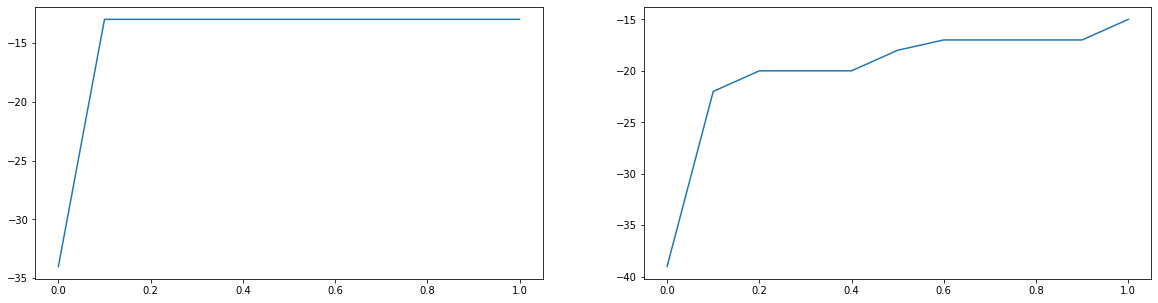

In [ ]:
fig = plt.figure(figsize=(20, 5))
x = [i/10 for i in range(0, 11)]
fig.add_subplot(1, 2, 1)
plt.plot(x, Qbest_rewards)

fig.add_subplot(1, 2, 2)
plt.plot(x, SARSA_best_rewards)
plt.show()

## 8. Experimental study on the 'environment size' parameter

#### 8.1. Environment size augmentation for QLearning and SARSA 

Best rewards QLearning = -25
Best rewards SARSA = -32


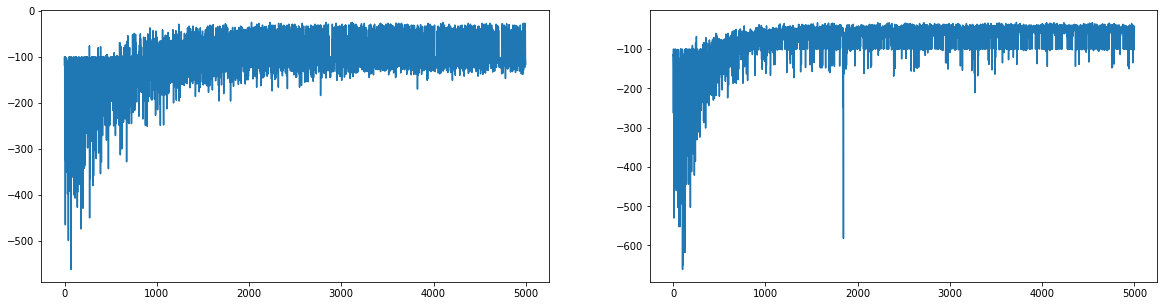

In [21]:
# Init new learning Agent
Agent = Cliffwalking(rows=8, columns=24)
Q_Table, Q_rewards = QLearning(agent=Agent ,Alpha=0.1, Gama=0.9, Egreedy=0.3, Time=5000)
SARSA_Table, SARSA_rewards = SARSA(agent=Agent ,Alpha=0.1, Gama=0.9, Egreedy=0.3, Time=5000)

# display results
fig = plt.figure(figsize=(20, 5))
x = [i for i in range(5000)]
fig.add_subplot(1, 2, 1)
plt.plot(x, Q_rewards)
print(f'Best rewards QLearning = {max(Q_rewards)}')

fig.add_subplot(1, 2, 2)
plt.plot(x, SARSA_rewards)
print(f'Best rewards SARSA = {max(SARSA_rewards)}')

plt.show()

In [22]:
print('1 - QLEARNING : ')
print(f'REWARDS : {Agent.bestEpisode(Q_Table)}\n\n')

print('2 - SARSA : ')
print(f'REWARDS : {Agent.bestEpisode(SARSA_Table)}')

1 - QLEARNING : 
|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 

|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 

|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 

|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 

|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 

|   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   |   | 

| R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | 

| R | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | C | R | 

REWARDS : -25


2 - SARSA : 
| R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R | R |   |   |   |   | 

| R |   |   |   |   |   |   |   |   |   |   |   |   | 